# Advanced Lane Findings

In [1]:
import os
import  shutil
import glob
import re
from datetime import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import imageio
import cv2
from tqdm import tqdm
import warnings
from helper_funcs import *
%load_ext autoreload

%autoreload 2
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (8, 5)

## Camera calibration

In [3]:
obj_pts = np.zeros((9 * 6, 3), np.float32)
obj_pts[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

output_dir = 'corners'
if not os.path.exists(output_dir): os.mkdir(output_dir)

num_parser = lambda x: int(re.search(r'\d+', x).group(0))
cal_img_paths = sorted(glob.glob(os.path.join('camera_cal', '*.jpg')), key=num_parser)

for idx, img_path in enumerate(cal_img_paths):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    # If found, add object points, image points
    if ret:
        print(idx, img_path)
        objpoints.append(obj_pts)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        cv2.imwrite(os.path.join(output_dir, os.path.basename(img_path)), img)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.T.shape[1:], None, None)

1 camera_cal/calibration2.jpg
2 camera_cal/calibration3.jpg
5 camera_cal/calibration6.jpg
6 camera_cal/calibration7.jpg
7 camera_cal/calibration8.jpg
8 camera_cal/calibration9.jpg
9 camera_cal/calibration10.jpg
10 camera_cal/calibration11.jpg
11 camera_cal/calibration12.jpg
12 camera_cal/calibration13.jpg
13 camera_cal/calibration14.jpg
14 camera_cal/calibration15.jpg
15 camera_cal/calibration16.jpg
16 camera_cal/calibration17.jpg
17 camera_cal/calibration18.jpg
18 camera_cal/calibration19.jpg
19 camera_cal/calibration20.jpg


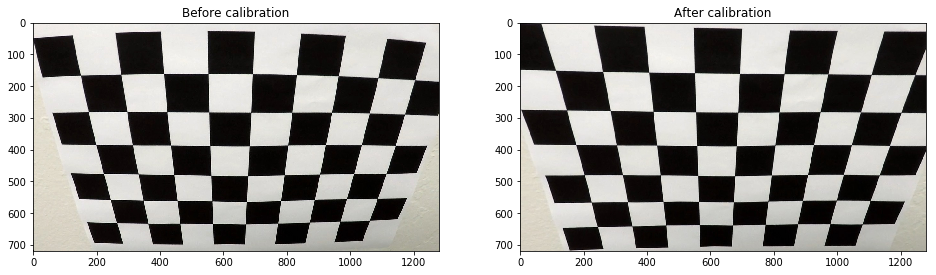

In [4]:
test_img_paths = glob.glob(os.path.join('test_images', '*.jpg'))
img = cv2.imread(cal_img_paths[1])
img_cal = cv2.undistort(img, mtx, dist, None, mtx)

fig_dir = 'figs'
if not os.path.exists(fig_dir): os.mkdir(fig_dir)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
ax1.imshow(img[:, :, ::-1])
ax1.set_title('Before calibration')
ax2.imshow(img_cal[:, :, ::-1])
ax2.set_title('After calibration')
plt.savefig(os.path.join(fig_dir, 'chess_calib.jpg'), bbox_inches='tight')
plt.show()

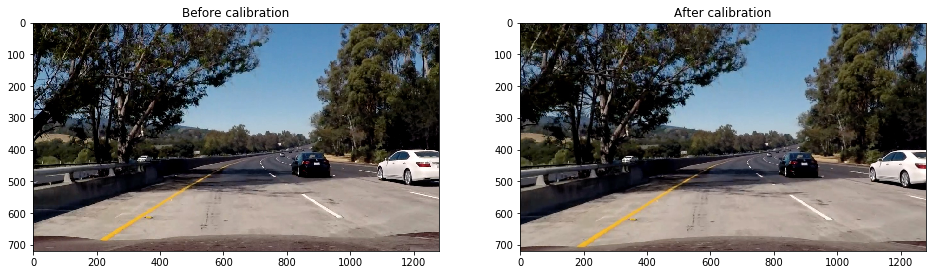

In [5]:
test_img_paths = glob.glob(os.path.join('test_images', '*.jpg'))
img = cv2.imread(test_img_paths[1])
img_cal = cv2.undistort(img, mtx, dist, None, mtx)

fig_dir = 'figs'
if not os.path.exists(fig_dir): os.mkdir(fig_dir)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 30))
ax1.imshow(img[:, :, ::-1])
ax1.set_title('Before calibration')
ax2.imshow(img_cal[:, :, ::-1])
ax2.set_title('After calibration')
plt.savefig(os.path.join(fig_dir, 'calib.jpg'), bbox_inches='tight')
plt.show()

The effect of calibration is very subtle.

## Color Spaces
Analyze the color space to determine threshold

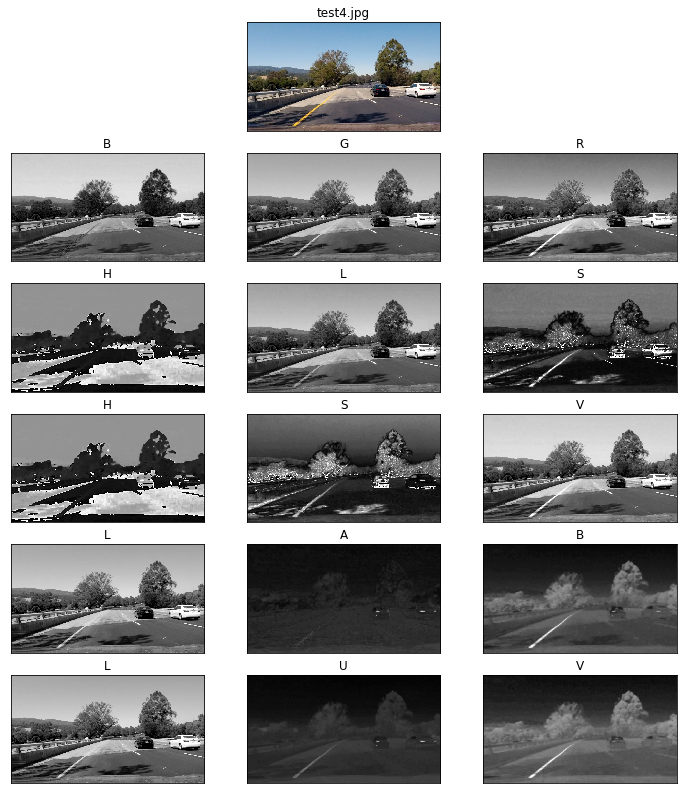

In [6]:
def colorspace(img_path):
    mapdict = {
        'BGR': None,
        'HLS': cv2.COLOR_BGR2HLS,
        'HSV': cv2.COLOR_BGR2HSV,
        'LAB': cv2.COLOR_BGR2LAB,
        'LUV': cv2.COLOR_BGR2LUV,
        
    }
    fig, axes = plt.subplots(len(mapdict) + 1, 3, sharey=True, figsize=(12, 14))
    fig.delaxes(axes[0][0])
    fig.delaxes(axes[0][2])
    
    img = cv2.imread(img_path)
    axes[0][1].imshow(img[:, :, ::-1])
    axes[0][1].set_title(os.path.basename(img_path))
    axes[0][1].set_xticks([])
    axes[0][1].set_yticks([])
    
    for i, (colorspace, cvt_code) in enumerate(mapdict.items()):
        img_cvt = cv2.cvtColor(img, cvt_code) if cvt_code else img.copy()
        colors = list(colorspace)
        for j in range(3):
            axes[i + 1][j].imshow(img_cvt[:, :, j], cmap='gray')
            axes[i + 1][j].set_title(colors[j])
            axes[i + 1][j].set_xticks([])
            axes[i + 1][j].set_yticks([])
#     plt.tight_layout()
    plt.show()

colorspace(test_img_paths[2])

## Gradients

I performed grid search to find good gradient threshold values.

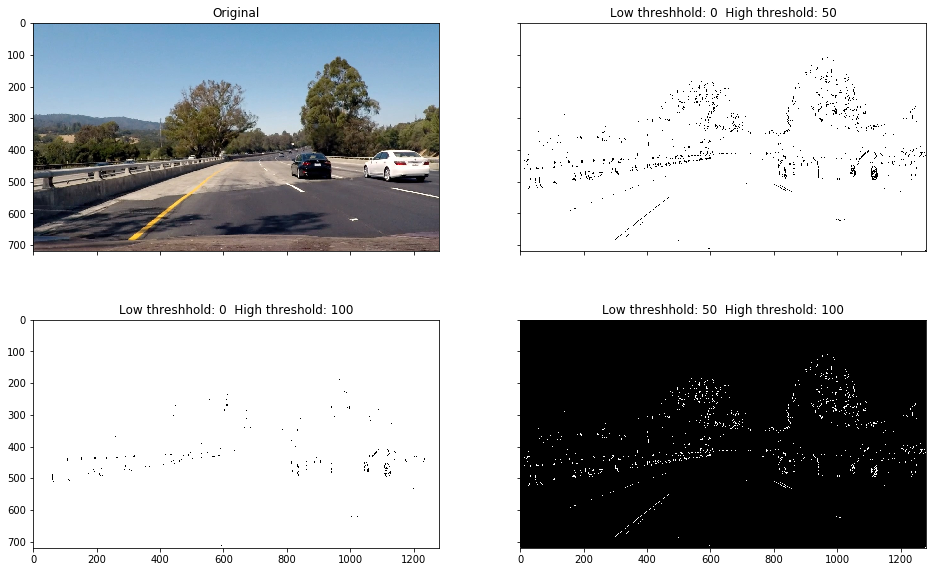

In [7]:
low_thresh_list = np.arange(0, 50 + 1, 50)
high_thresh_list = np.arange(0, 100 + 1, 50)

low, high = np.meshgrid(low_thresh_list, high_thresh_list)
idx = (low < high)
lows = low[idx]
highs = high[idx]

cols = 2
q, mod = divmod(len(lows), cols)
rows = q + int(mod > 0)
img = cv2.imread(test_img_paths[2])

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5),  sharex=True, sharey=True)
axes = axes.ravel()

axes[0].imshow(img[:, :, ::-1])
axes[0].set_title('Original')

for i, ax in enumerate(axes[1:]):
    if i > len(lows) - 1:
        fig.delaxes(ax)
        continue
    binary = abs_sobel_thresh(img, orient='x', thresh=(lows[i], highs[i]))
#     binary = abs_sobel_thresh(img, orient='x', thresh=(lows[i], highs[i]))
#     binary = mag_thresh(img, thresh=(lows[i], highs[i]))
    ax.imshow(binary, cmap='gray')
    ax.set_title('Low threshhold: {}  High threshold: {}'.format(lows[i], highs[i]))
    
plt.show()

## Combine color space and gradient

In [8]:
def binarize(img):
    xgrad_thresh = (25, 50)
    xgrad_binary = abs_sobel_thresh(img, orient='x', thresh=xgrad_thresh)
    
    white_lower = np.uint8([  0, 200,   0])
    white_upper = np.uint8([255, 255, 255])
    yellow_lower = np.uint8([ 10,   0, 100])
    yellow_upper = np.uint8([ 40, 255, 255])
    yellow_mask = hls_thresh(img, yellow_lower, yellow_upper)
    white_mask = hls_thresh(img, white_lower, white_upper)
    hls_binary = cv2.bitwise_or(white_mask, yellow_mask).astype(np.uint8)
    
    binary = xgrad_binary | hls_binary
    return binary

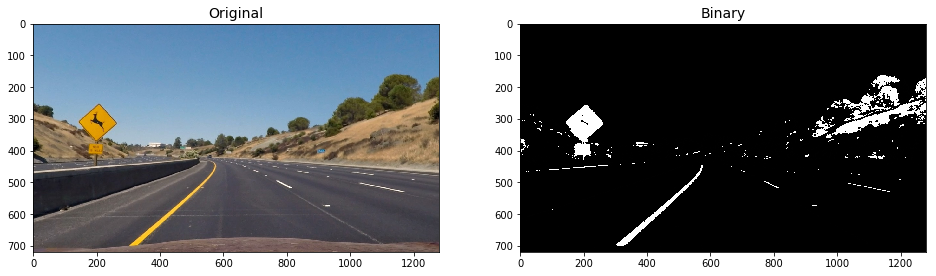

In [9]:
img = img = cv2.imread(test_img_paths[5])

img = cv2.undistort(img, mtx, dist, None, mtx)
h, w, c = img.shape

binary = binarize(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
ax1.imshow(img[:, :, ::-1])
ax1.set_title('Original', fontsize=14)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Binary', fontsize=14)
plt.savefig(os.path.join(fig_dir, 'binary.jpg'), bbox_inches='tight')
plt.show()

## Warp lane lines

In [10]:
def warp(binary, src=None):
    if src is None:
        _, left_fit_line, right_fit_line = pipeline_P1(binary)
        src = np.array([
            left_fit_line[:2],
            right_fit_line[:2],
            right_fit_line[2:],
            left_fit_line[2:],
        ])

    bin_src = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    cv2.polylines(bin_src, src.reshape((-1, 4, 2)), True, (0, 255, 0), 3)
    src = src.astype(np.float32)
    dst = calc_warp_dst(src, binary.shape)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    bin_warped = cv2.warpPerspective(binary, M, (w, h), flags=cv2.INTER_LINEAR)
    return bin_warped, bin_src, M, Minv, src, dst

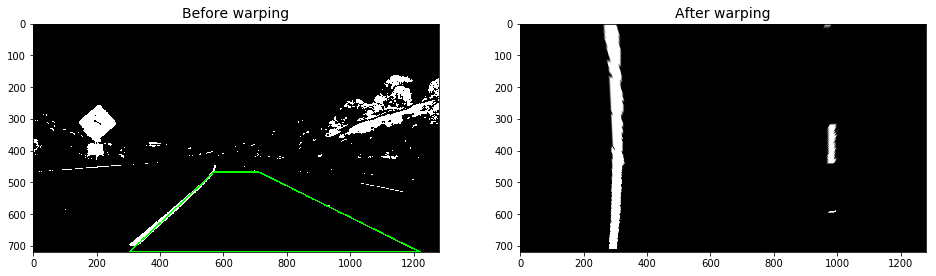

In [11]:
bin_warped, bin_src, M, Minv, src, dst = warp(binary)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
ax1.imshow(bin_src[:, :, ::-1])
ax1.set_title('Before warping', fontsize=14)
ax2.imshow(bin_warped, cmap='gray')
ax2.set_title('After warping', fontsize=14)
plt.savefig(os.path.join(fig_dir, 'warped.jpg'), bbox_inches='tight')
plt.show()

The green line represents an area to be warped.

## Find Peaks in histogram

In [12]:
def find_peaks(bin_warped):
    hist = calc_hist(bin_warped)
    mid = bin_warped.shape[1] // 2
    left_peak_idx = np.argmax(hist[:mid])
    right_peak_idx = mid + np.argmax(hist[mid:])
    return hist, left_peak_idx, right_peak_idx

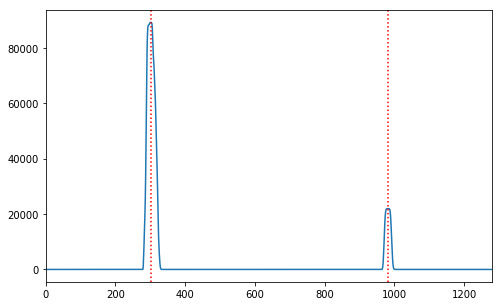

In [13]:
hist, left_peak_idx, right_peak_idx = find_peaks(bin_warped)
plt.plot(hist)
plt.xlim(0, bin_warped.shape[1])
plt.axvline(left_peak_idx, color='r', linestyle=':')
plt.axvline(right_peak_idx, color='r', linestyle=':')
plt.savefig(os.path.join(fig_dir, 'peaks.jpg'), bbox_inches='tight')
plt.show()

## Sliding windows to fine lane pixels

In [14]:
def within_range(x, lower, upper):
    return (x >= lower) & (x < upper)

def find_lane_pixels(bin_warped):
    """
    img must be a warped image
    """
    nwindows = 9
    margin = 100
    minpix = 50
    
    histogram, left_peak_idx, right_peak_idx = find_peaks(bin_warped)
    window_height = np.int(bin_warped.shape[0]//nwindows)
    window_bottom_ys = np.flipud(window_height * np.arange(nwindows)).round().astype(np.int32)
    window_top_ys = np.flipud(window_height * np.arange(1, nwindows + 1)).round().astype(np.int32)
    nonzero = bin_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = left_peak_idx
    rightx_current = right_peak_idx

    left_lane_idxs = []
    right_lane_idxs = []
    
    img_out = cv2.cvtColor(bin_warped.copy(), cv2.COLOR_GRAY2BGR)
    for i in range(nwindows):
        lt_left = (leftx_current - margin, window_top_ys[i])
        br_left = (leftx_current + margin, window_bottom_ys[i])
        lt_right = (rightx_current - margin, window_top_ys[i])
        br_right = (rightx_current + margin, window_bottom_ys[i])
        cv2.rectangle(img_out, lt_left, br_left, (0, 255, 0), 2)
        cv2.rectangle(img_out, lt_right, br_right, (0, 255, 0), 2)
        left_idxs = (within_range(nonzeroy, br_left[1], lt_left[1]) & within_range(nonzerox, lt_left[0], br_left[0])).nonzero()[0]
        right_idxs = (within_range(nonzeroy, br_right[1], lt_right[1]) & within_range(nonzerox, lt_right[0], br_right[0])).nonzero()[0]
        left_lane_idxs.append(left_idxs)
        right_lane_idxs.append(right_idxs)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(left_idxs) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_idxs]))
        if len(right_idxs) > minpix:     
            rightx_current = np.int(np.mean(nonzerox[right_idxs]))
        
    left_lane_idxs = np.concatenate(left_lane_idxs)
    right_lane_idxs = np.concatenate(right_lane_idxs)

    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs] 
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs]

    img_out[lefty, leftx] = [255, 0, 0]
    img_out[righty, rightx] = [0, 0, 255]

    return leftx, lefty, rightx, righty, img_out

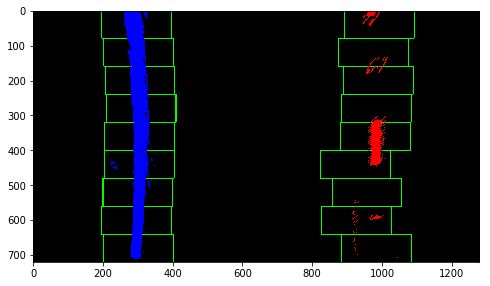

In [15]:
leftx, lefty, rightx, righty, img_out = find_lane_pixels(bin_warped)
plt.imshow(img_out[: ,:, ::-1])
plt.savefig(os.path.join(fig_dir, 'slide_window.jpg'), bbox_inches='tight')

## Fit lane lines

In [16]:
def fit_poly(img, leftx, lefty, rightx, righty):
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    leftx_fit = np.polyval(left_fit, y)
    rightx_fit = np.polyval(right_fit, y)
    return left_fit, right_fit, leftx_fit, rightx_fit, y

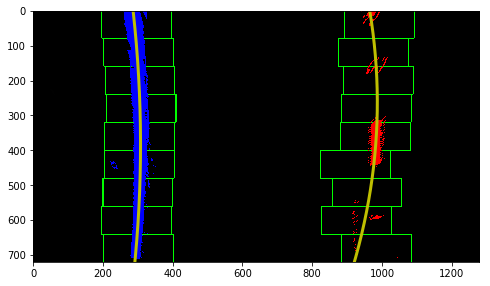

In [17]:
left_fit, right_fit, leftx_fit, rightx_fit, y = fit_poly(bin_warped, leftx, lefty, rightx, righty)
plt.imshow(img_out[: ,:, ::-1])
plt.plot(leftx_fit, y, 'y', lw=3)
plt.plot(rightx_fit, y, 'y', lw=3)
plt.savefig(os.path.join(fig_dir, 'fit_line.jpg'), bbox_inches='tight')

## Search from prior

In [18]:
def search_from_prior(binary_warped, left_fit, right_fit):
    margin = 75
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit_line = np.polyval(left_fit, nonzeroy)
    right_fit_line = np.polyval(right_fit, nonzeroy)

    left_lane_idxs = ((nonzerox > (left_fit_line - margin)) & (nonzerox < left_fit_line + margin))
    right_lane_idxs = ((nonzerox > (right_fit_line - margin)) & (nonzerox < (right_fit_line + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs] 
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs]
    
    y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_lines = np.vstack((np.polyval(left_fit, y) - margin, y)).T.round().astype(np.int32).reshape((1, -1, 2))
    right_lines = np.vstack((np.polyval(left_fit, y) + margin, y)).T.round().astype(np.int32).reshape((1, -1, 2))
    left_window = np.concatenate((left_lines, np.flip(right_lines, axis=1)), axis=1)
    
    left_lines = np.vstack((np.polyval(right_fit, y) - margin, y)).T.round().astype(np.int32).reshape((1, -1, 2))
    right_lines = np.vstack((np.polyval(right_fit, y) + margin, y)).T.round().astype(np.int32).reshape((1, -1, 2))
    right_window = np.concatenate((left_lines, np.flip(right_lines, axis=1)), axis=1)
    
    window_img = np.zeros_like(binary_warped).astype(np.uint8)
    window_img = np.dstack((window_img,)*3)
    
    cv2.fillPoly(window_img, left_window, (0,255, 0))
    cv2.fillPoly(window_img, right_window, (0,255, 0))
    
    img_out = cv2.cvtColor(binary_warped.copy(), cv2.COLOR_GRAY2BGR)
    img_out[lefty, leftx] = [255, 0, 0]
    img_out[righty, rightx] = [0, 0, 255]
    img_out = cv2.addWeighted(img_out, 1, window_img, 0.3, 0)
    
    return leftx, lefty, rightx, righty, img_out

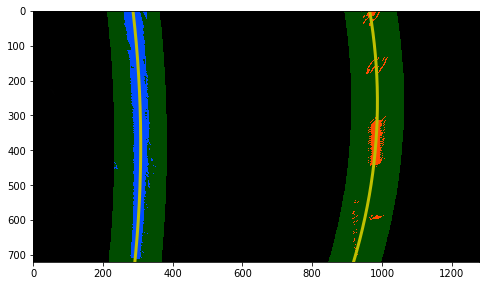

In [19]:
leftx, lefty, rightx, righty, img_out = search_from_prior(bin_warped, left_fit, right_fit)
left_fit, right_fit, leftx_fit, rightx_fit, y = fit_poly(bin_warped, leftx, lefty, rightx, righty)
plt.imshow(img_out[: ,:, ::-1])
plt.plot(leftx_fit, y, 'y', lw=3)
plt.plot(rightx_fit, y, 'y', lw=3)
plt.savefig(os.path.join(fig_dir, 'prior.jpg'), bbox_inches='tight')

## Unwarp lane lines

In [20]:
def unwarp(img_org, binary_warped, Minv, leftx_fit, rightx_fit, y):
    bg = np.zeros_like(binary_warped).astype(np.uint8)
    bg = np.dstack((bg,)*3)

    left_lines = np.vstack((leftx_fit, y)).T.astype(np.int32).reshape((1, -1, 2))
    right_lines = np.vstack((rightx_fit, y)).T.astype(np.int32).reshape((1, -1, 2))
    poly = np.concatenate((left_lines, np.flip(right_lines, axis=1)), axis=1)
    cv2.fillPoly(bg, poly, (0,255, 0))
    cv2.polylines(bg, left_lines, False, (255, 0, 0), 15)
    cv2.polylines(bg, right_lines, False, (0, 0, 255), 15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(bg, Minv, (img_org.shape[1], img_org.shape[0]))
    img_final = cv2.addWeighted(img_org, 1, unwarped, 0.5, 0)
    return img_final

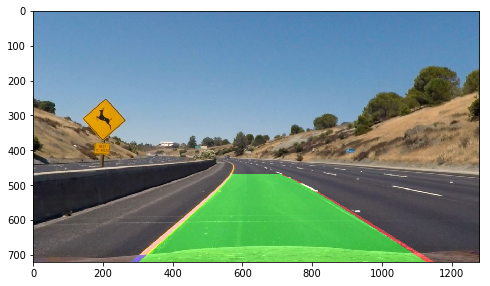

In [21]:
img_final = unwarp(img, bin_warped, Minv, leftx_fit, rightx_fit, y)
# Combine the result with the original image

plt.imshow(img_final[:, :, ::-1])
plt.savefig(os.path.join(fig_dir, 'final.jpg'), bbox_inches='tight')

## Measure curvature radius and offset of center

In [22]:
def calc_curvrad(x, y):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    p = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    return ((1 + (2*p[0]*y[-1]*ym_per_pix + p[1])**2)**1.5) / np.abs(2*p[0])

def calc_offset(leftx_fit, rightx_fit, img_shape):
    lane_center = (leftx_fit[-1] + rightx_fit[-1])/2
    xm_per_pix = 3.7/700
    center_offset = (xm_per_pix * np.abs(lane_center - img_shape[1]/2)).round(2)
    direction = 'right' if (lane_center - img_final.shape[1]/2) > 0 else 'left'
    return center_offset, direction

In [23]:
left_curvrad = calc_curvrad(leftx_fit, y)
right_curvrad = calc_curvrad(rightx_fit, y)
ave_curvrad = np.average((left_curvrad, right_curvrad)).round(1)
print('Left curvature radius:', left_curvrad)
print('Right curvature radius:', right_curvrad)
print('Average curvature radius:', ave_curvrad)

center_offset, direction = calc_offset(leftx_fit, rightx_fit, img.shape)
print('Center offset: {} m'.format(center_offset))

Left curvature radius: 1097.2385239641565
Right curvature radius: 505.8838599281804
Average curvature radius: 801.6
Center offset: 0.18 m


## Put text on image

In [24]:
def stamp_text(img, texts):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.8
    margin = 20
    thickness = 2
    color = (255, 255, 255)

    text_size = cv2.getTextSize(texts[0], font, font_scale, thickness)
    text_width = text_size[0][0]
    text_height = text_size[0][1]
    line_height = text_height + text_size[1] + margin
    y0 = margin + text_height
    dy = text_height * 1.5
    x = margin
    
    for i, text in enumerate(texts):
        y = int(y0 + i * dy)
        cv2.putText(img, text, (x, y), font, font_scale, color, thickness) 

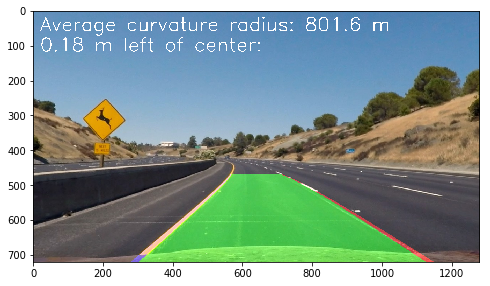

In [25]:
texts = [
    'Average curvature radius: {} m'.format(ave_curvrad), 
    '{} m {} of center: '.format(center_offset, direction), 
]
img_final_text = img_final.copy()
stamp_text(img_final_text, texts)
plt.imshow(img_final_text[:, :, ::-1])
plt.savefig(os.path.join(fig_dir, 'final_text.jpg'), bbox_inches='tight')

## Define pipeline

In [26]:
def pipeline(img, left_fit=None, right_fit=None, src=None):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    binary = binarize(img)
    binary_warped, _, M, Minv, src, _ = warp(binary, src)
    
    if left_fit is None:
        leftx, lefty, rightx, righty, img_out = find_lane_pixels(binary_warped)
    else:
        leftx, lefty, rightx, righty, img_out = search_from_prior(binary_warped, left_fit, right_fit)
    left_fit, right_fit, leftx_fit, rightx_fit, y = fit_poly(binary_warped, leftx, lefty, rightx, righty)
    img_final = unwarp(img, binary_warped, Minv, leftx_fit, rightx_fit, y)
    line_edges = np.array([[
        [leftx_fit[0], y[0]],
        [rightx_fit[0], y[0]],
        [rightx_fit[-1], y[-1]],
        [leftx_fit[-1], y[-1]],
    ]])
    
    line_edges = cv2.perspectiveTransform(line_edges, Minv).round().astype(np.int32)  # https://qiita.com/ossyaritoori/items/f7bf63ad50028d1ee858
#     print(src)
#     for xy in src:
#         cv2.circle(img_final, tuple(xy), 5, (255, 0, 0), -1)
    
    for x, y in line_edges[0]:
        cv2.circle(img_final, (x, y), 5, (0, 0, 255), -1)
    
    return img_final, left_fit, right_fit, leftx_fit, rightx_fit, line_edges

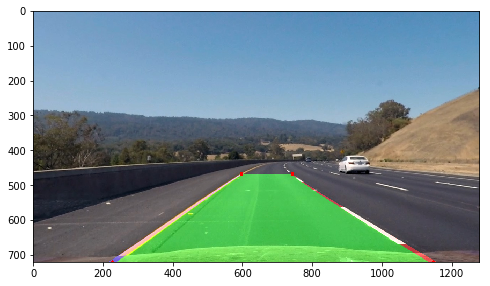

In [28]:
img = cv2.imread(test_img_paths[4])
img_final, leftx_fit, rightx_fit, leftx_fit, rightx_fit, src = pipeline(img)
plt.imshow(img_final[:, :, ::-1])

## Apply the pipeline to a video

In [29]:
video_path = 'project_video.mp4'
frame_dir = os.path.splitext(video_path)[0] + '_frames'
reader = imageio.get_reader(video_path)
fps = reader.get_meta_data()['fps']
left_fit= None
right_fit= None
src = None

if not os.path.exists(frame_dir):
    os.mkdir(frame_dir)
else:
    empty_dir(frame_dir)

writer = imageio.get_writer('project_video_processed.mp4', fps=fps)
for i, frame in enumerate(tqdm(reader)):
    img_final, left_fit, right_fit, leftx_fit, rightx_fit, src = pipeline(frame[:, :, ::-1], left_fit, right_fit, src)
    
    # calculate curvature radius and put it on image
    left_curvrad = calc_curvrad(leftx_fit, y)
    right_curvrad = calc_curvrad(rightx_fit, y)
    ave_curvrad = np.average((left_curvrad, right_curvrad)).round(1)
    center_offset, direction = calc_offset(leftx_fit, rightx_fit, img.shape)
    texts = [
        'Average curvature radius: {} m'.format(ave_curvrad),
        '{} m {} of center: '.format(center_offset, direction), 
    ]
    img_final_text = img_final.copy()
    stamp_text(img_final, texts)
    
    save_path = os.path.join(frame_dir, '{}.jpg'.format(i))
    cv2.imwrite(save_path, img_final)
    writer.append_data(img_final[:, :, ::-1])
writer.close()

100%|██████████| 1260/1260 [03:07<00:00,  6.73it/s]


In [30]:
video_path = 'harder_challenge_video.mp4'
frame_dir = os.path.splitext(video_path)[0] + '_frames'
reader = imageio.get_reader(video_path)
fps = reader.get_meta_data()['fps']

if not os.path.exists(frame_dir):
    os.mkdir(frame_dir)
else:
    empty_dir(frame_dir)

for i, frame in enumerate(tqdm(reader)):
    save_path = os.path.join(frame_dir, '{}.jpg'.format(i))
    cv2.imwrite(save_path, frame[:, :, ::-1])


100%|██████████| 1199/1199 [01:13<00:00, 16.32it/s]
